# Predicting Stock Price Using Machine Learning

**Project notebook**

This notebook follows the project proposal: it loads historical OHLCV stock data from `Data/Stocks/"<stock_name>".us.txt`, computes technical indicators, trains baseline models (Logistic Regression, Random Forest, SVM), demonstrates an LSTM setup, and evaluates results using Accuracy, F1, RMSE, and MAE.

**Notes / assumptions:**
- Files are expected in CSV format with at least the columns: `Date, Open, High, Low, Close, Volume`.
- Replace `stock_name` variable below with the ticker filename (without `.us.txt`).
- This notebook contains model training examples but does not run long trainings by default.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime 
from datetime import date, datetime
import math
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [3]:
# Dirctory containing stock data files
data_dir = 'Data/Stocks'

# replace with the filename prefix (without .us.txt). Look in Data/Stocks for available files
stock_name = 'AAPL'


filepath = os.path.join(data_dir, f"{stock_name}.us.txt")
print('\nLoading:', filepath)


Loading: Data/Stocks\AAPL.us.txt


In [4]:
# Load necessary columns
cols_to_load = ['Date', 'Close']  # Only Close is needed for 'Price'
data = pd.read_csv(filepath, usecols=cols_to_load)

# Convert Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Sort by date
data = data.sort_values('Date').reset_index(drop=True)

# Rename Close to Price
data = data.rename(columns={'Close': 'Price'})

# Set Date as index
data.set_index('Date', inplace=True)

print('Data range:', data.index.min(), 'to', data.index.max())
data.head()

Data range: 1984-09-07 00:00:00 to 2017-11-10 00:00:00


,Price
Date,
1984-09-07,0.42388
1984-09-10,0.42134
1984-09-11,0.42902
1984-09-12,0.41618
1984-09-13,0.43927


In [5]:
print('There are {} number of days in the dataset.'.format(data.shape[0]))

There are 8364 number of days in the dataset.


In [6]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Price'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Price'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['Price'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Price'].ewm(span=12).mean()
    dataset['MACD'] = dataset['12ema']-dataset['26ema']

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Price'].rolling(window = 21).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Price'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['Price'].diff(1)  # change from previous day
    dataset['log_momentum'] = np.log(dataset['Price'] / dataset['Price'].shift(1))

    return dataset

df = get_technical_indicators(data)
df = df.dropna()
df.head()

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
1984-10-05,0.39699,0.400277,0.420042,0.413878,0.407676,-0.006202,0.017938,0.455918,0.384166,0.399185,-0.00894,-0.022270
1984-10-08,0.39699,0.398260,0.418762,0.412345,0.405989,-0.006356,0.018598,0.455958,0.381566,0.397722,0.00000,0.000000
1984-10-09,0.39316,0.397167,0.417420,0.410632,0.403972,-0.006660,0.019402,0.456224,0.378616,0.394681,-0.00383,-0.009694
1984-10-10,0.38164,0.395707,0.415164,0.408082,0.400473,-0.007609,0.020697,0.456558,0.373769,0.385987,-0.01152,-0.029739
1984-10-11,0.37906,0.393511,0.413396,0.405565,0.397127,-0.008438,0.022141,0.457678,0.369115,0.381369,-0.00258,-0.006783


## Stock Price and Technical Indicators Visualization

This section visualizes the historical stock prices and key technical indicators to better understand market trends and momentum.

### 1. Closing Price History
The function `plot_stock_price()` generates a line chart of the stock's closing price over time. This helps identify long-term trends, patterns, and potential support/resistance levels.

- **X-axis:** Date
- **Y-axis:** Stock Price (in Rs)
- **Color:** Blue line represents the closing price
- **Purpose:** Visual overview of the stock's historical performance.

### 2. Technical Indicators
The function `plot_technical_indicators()` visualizes key technical indicators for the stock, including:

- **Moving Averages (MA7, MA21):** Short-term and medium-term trend lines (green and red dashed lines).
- **Price Bands (Upper & Lower):** Highlight volatility and price channels (cyan lines with shaded area).
- **MACD:** Trend momentum indicator (second subplot, dash-dot line).
- **Momentum:** Log-momentum line (blue solid line) to capture short-term price momentum.

The plots focus on the last `n` days (`last_days=500` in the example) to analyze recent price behavior and trends.

### 3. Correlation Heatmap
A heatmap of the correlation matrix is generated using `sns.heatmap()` to identify relationships between different technical indicators and the closing price.

- **Purpose:** Identify which indicators are most strongly correlated with the stock price, which can guide feature selection for machine learning models.
- **Visualization:** Annotated heatmap showing correlation coefficients between all parameters.

These visualizations provide a foundation for understanding the stock's behavior and informing feature selection for predictive modeling.


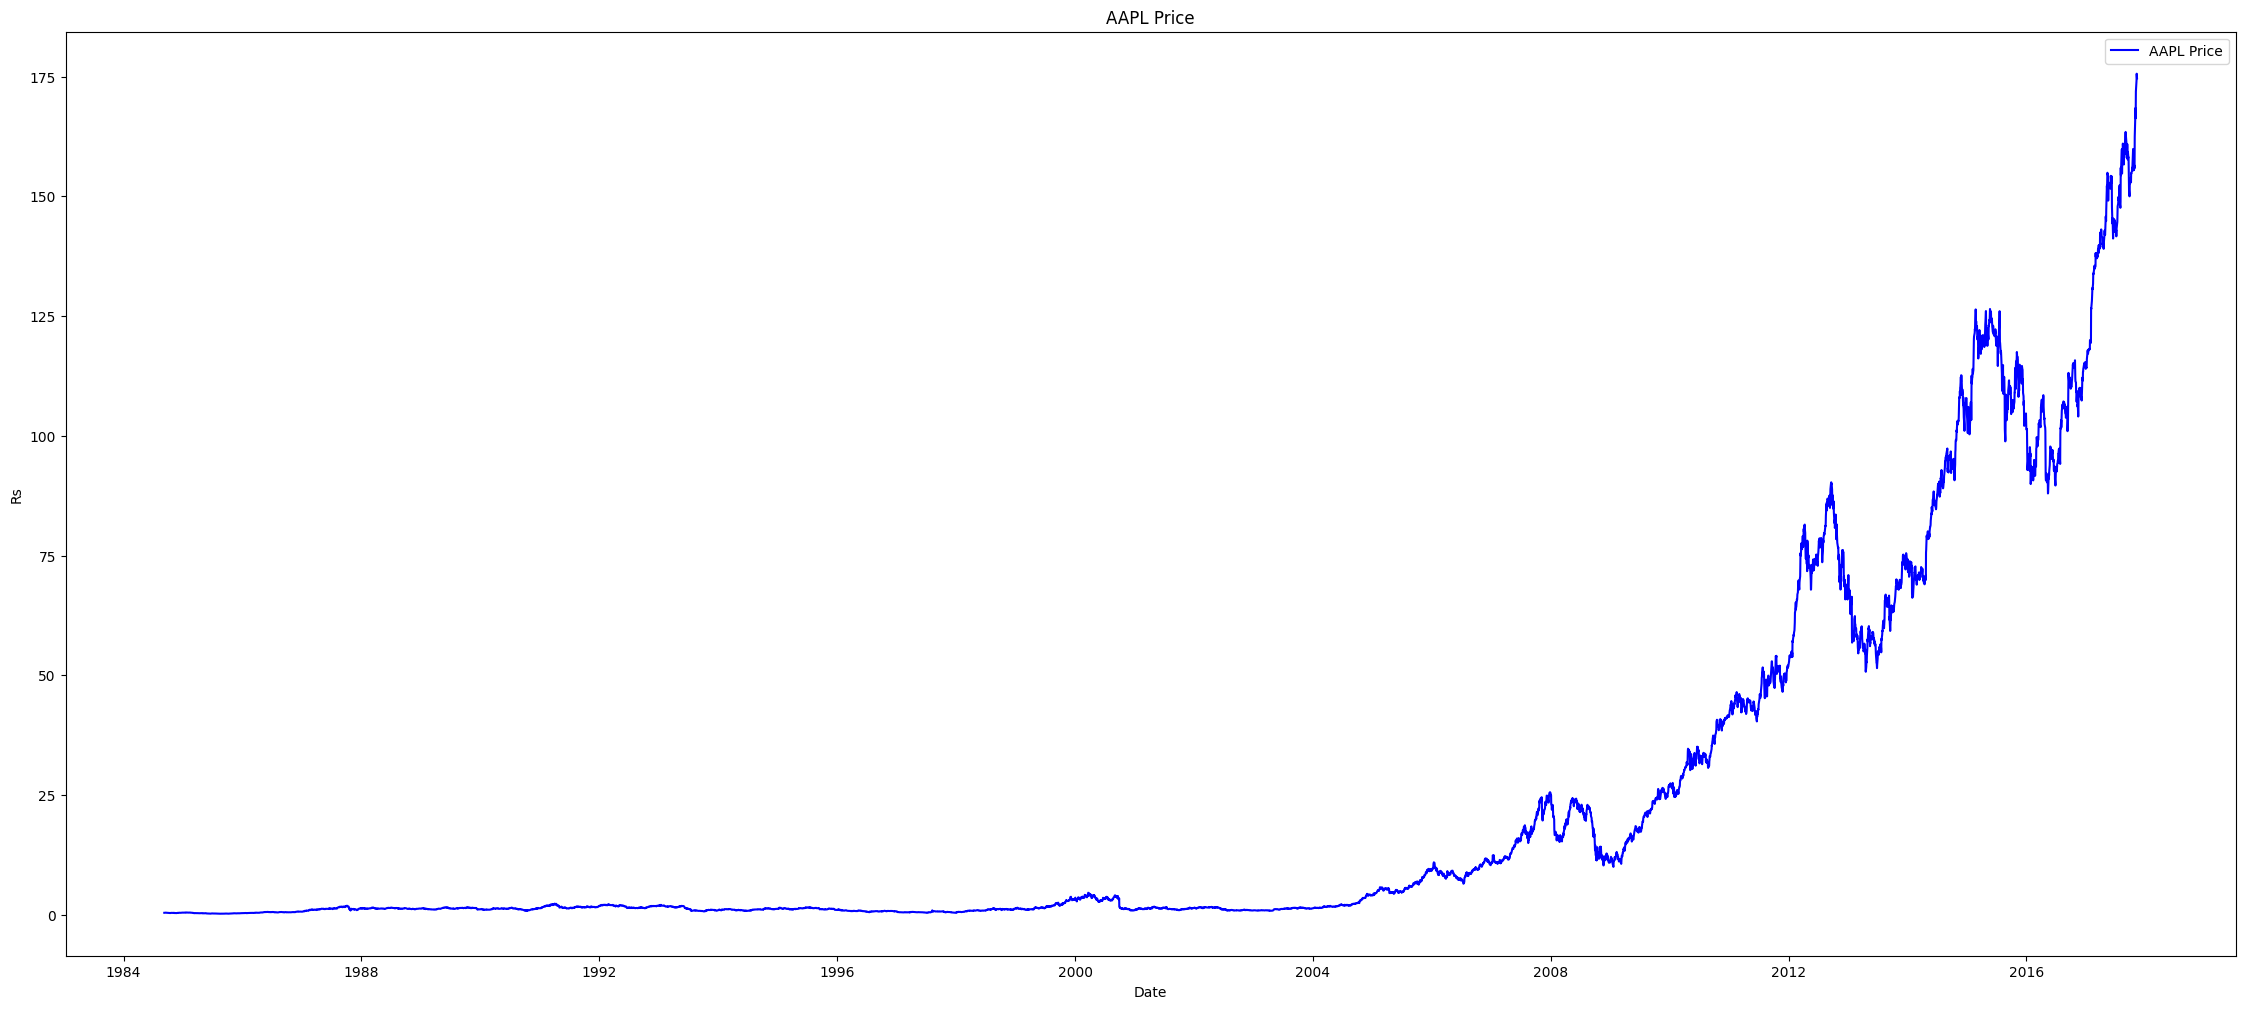

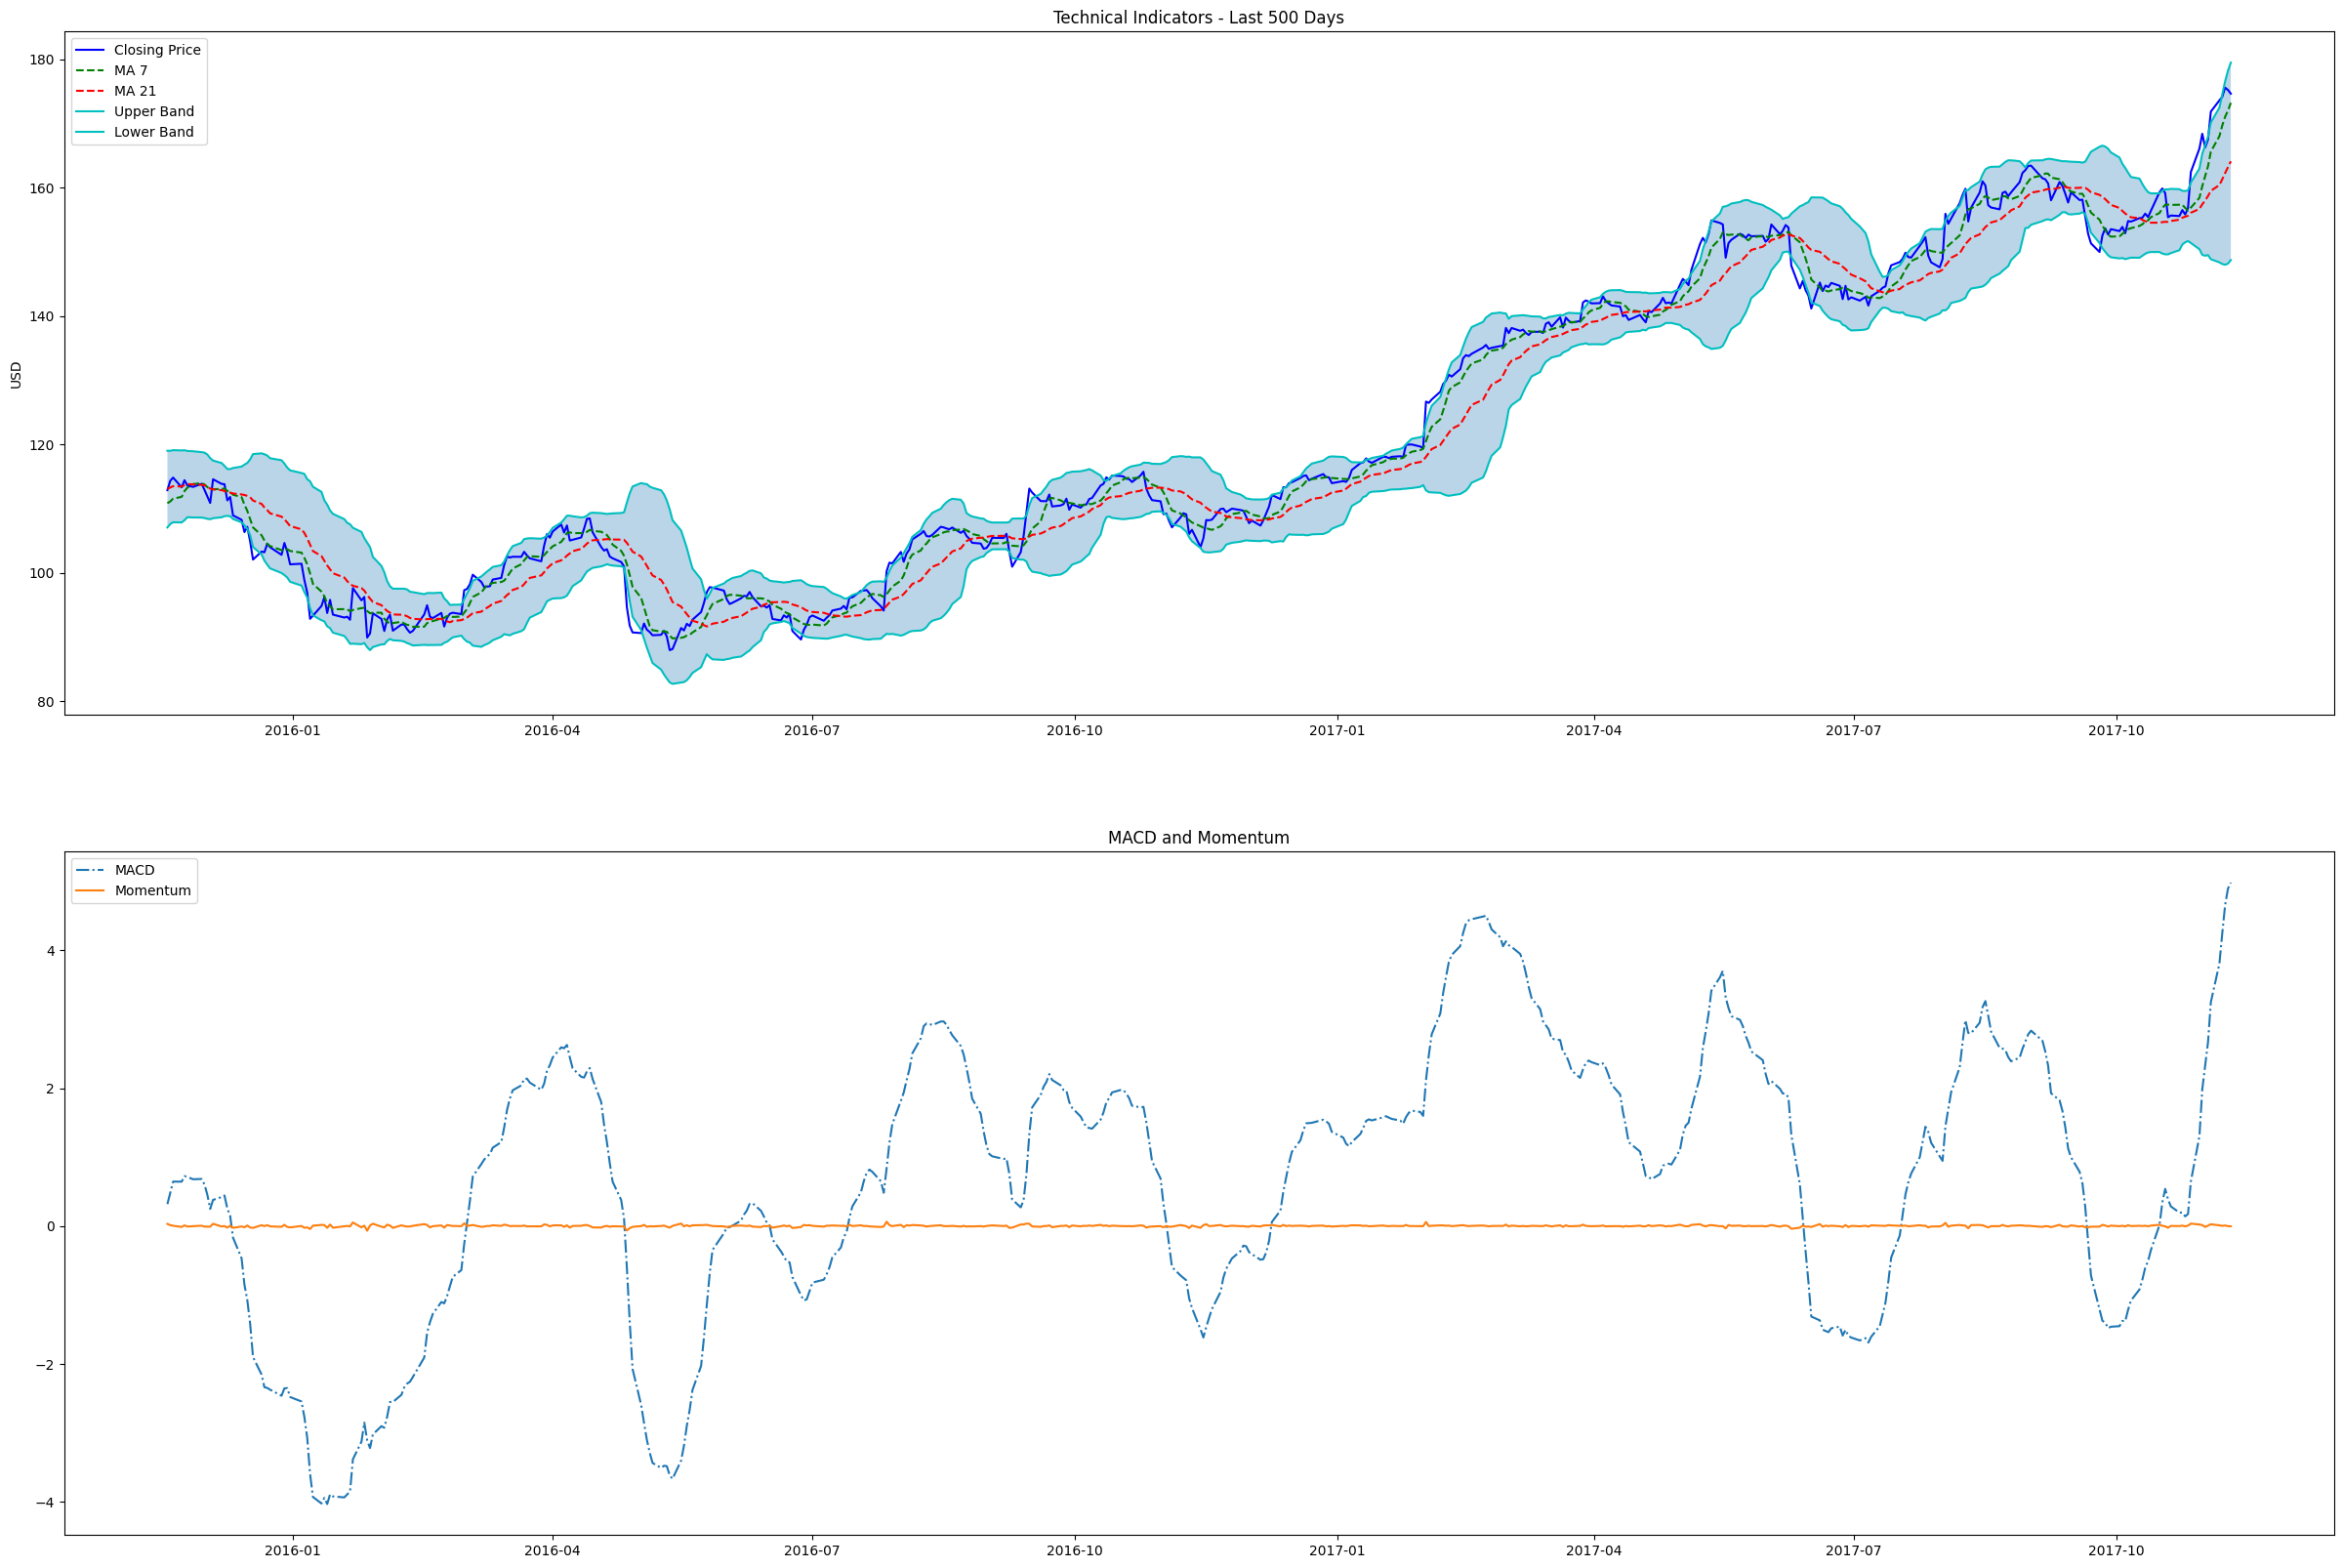

In [7]:
def plot_stock_price(dataset):
    """
    Plot the closing price history for the past `years` years.
    """
    plt.figure(figsize=(28, 12))
    plt.plot(data.index, data['Price'], label=f"{stock_name} Price", color='blue')
    plt.xlabel('Date')
    plt.ylabel('Rs')
    plt.title(f'{stock_name} Price')
    plt.legend()
    plt.show()

def plot_technical_indicators(dataset, last_days):
    if 'Date' in dataset.columns:
        dataset = dataset.copy()
        dataset['Date'] = pd.to_datetime(dataset['Date'])
        dataset = dataset.set_index('Date')

    data_slice = dataset.iloc[-last_days:].copy()
    dates = data_slice.index

    plt.figure(figsize=(30, 20))

    # Subplot 1: MA + Bollinger Bands
    plt.subplot(2, 1, 1)
    plt.plot(dates, data_slice['Price'], label='Closing Price', color='b')
    plt.plot(dates, data_slice['ma7'], label='MA 7', color='g', linestyle='--')
    plt.plot(dates, data_slice['ma21'], label='MA 21', color='r', linestyle='--')

    plt.plot(dates, data_slice['upper_band'], label='Upper Band', color='c')
    plt.plot(dates, data_slice['lower_band'], label='Lower Band', color='c')
    plt.fill_between(dates, data_slice['lower_band'], data_slice['upper_band'], alpha=0.3)

    plt.title(f"Technical Indicators - Last {last_days} Days")
    plt.ylabel("USD")
    plt.legend()

    # Subplot 2: MACD + Momentum
    plt.subplot(2, 1, 2)
    plt.plot(dates, data_slice['MACD'], label='MACD', linestyle='-.')
    plt.plot(dates, data_slice['log_momentum'], label='Momentum', linestyle='-')

    plt.title("MACD and Momentum")
    plt.legend()

    plt.show()


plot_stock_price(data)
plot_technical_indicators(df, last_days=500)


Text(0.5, 1.0, 'Params')

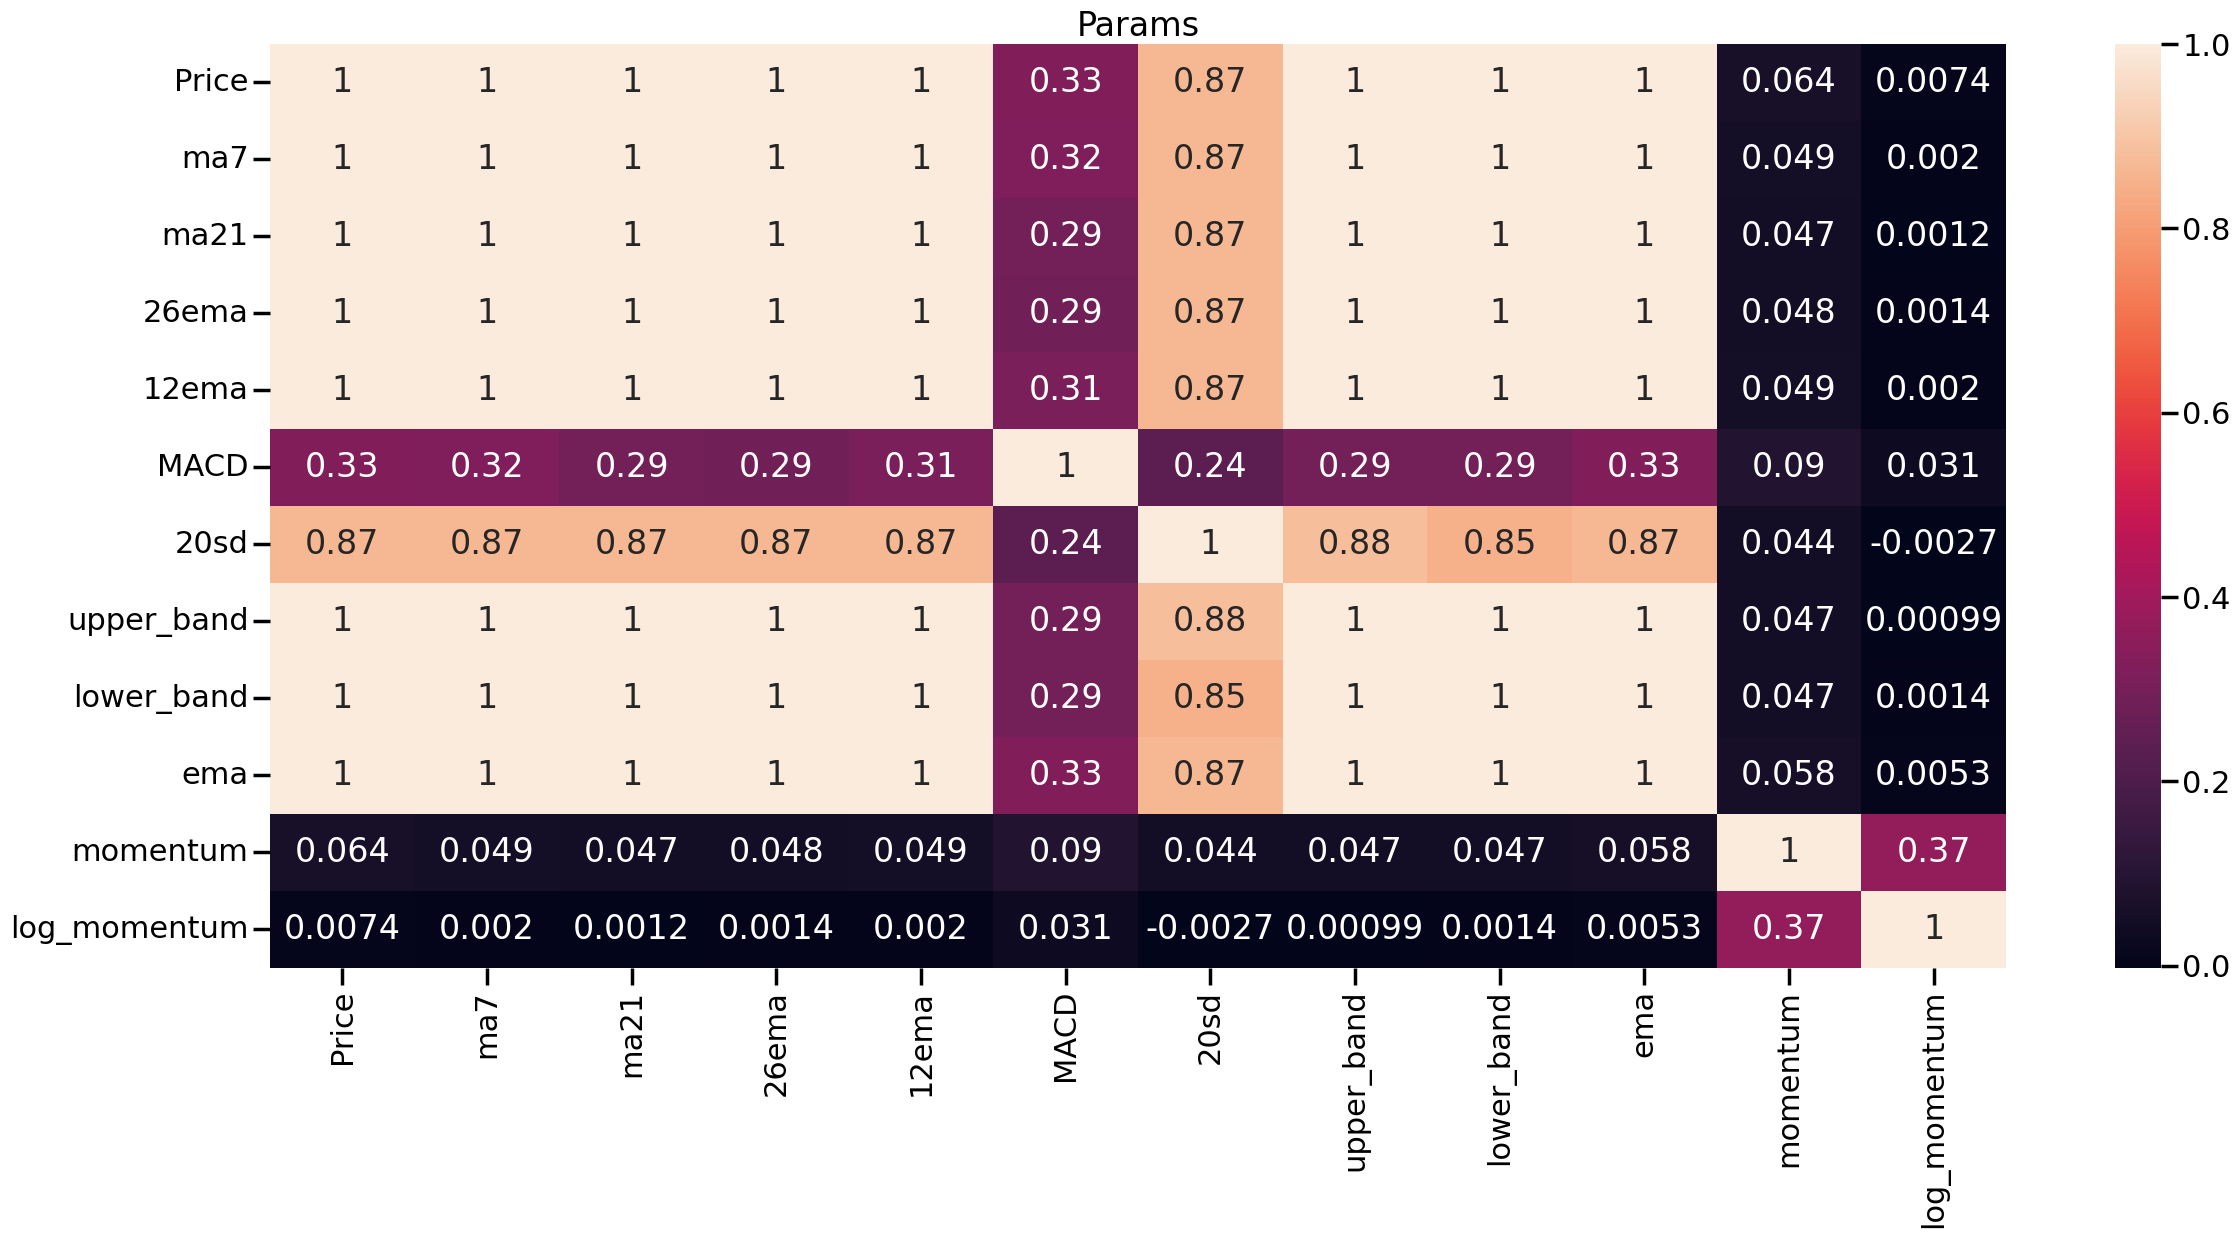

In [8]:
plt.figure(figsize = (28,12))
sns.set_context('poster',font_scale=1)
sns.heatmap(df.corr(), annot = True).set_title('Params')


In [9]:
print('Total dataset has {} samples, and {} features.'.format(df.shape[0], df.shape[1]))
df

Total dataset has 8344 samples, and 12 features.


,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
1984-10-05,0.39699,0.400277,0.420042,0.413878,0.407676,-0.006202,0.017938,0.455918,0.384166,0.399185,-0.00894,-0.022270
1984-10-08,0.39699,0.398260,0.418762,0.412345,0.405989,-0.006356,0.018598,0.455958,0.381566,0.397722,0.00000,0.000000
1984-10-09,0.39316,0.397167,0.417420,0.410632,0.403972,-0.006660,0.019402,0.456224,0.378616,0.394681,-0.00383,-0.009694
1984-10-10,0.38164,0.395707,0.415164,0.408082,0.400473,-0.007609,0.020697,0.456558,0.373769,0.385987,-0.01152,-0.029739
1984-10-11,0.37906,0.393511,0.413396,0.405565,0.397127,-0.008438,0.022141,0.457678,0.369115,0.381369,-0.00258,-0.006783
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-06,173.63000,168.047143,160.436667,161.337489,165.144058,3.806569,6.025726,172.488119,148.385215,172.525132,1.75000,0.010130
2017-11-07,174.18000,169.720000,161.336667,162.288786,166.534203,4.245416,6.601005,174.538678,148.134656,173.628377,0.55000,0.003163
2017-11-08,175.61000,171.075714,162.301905,163.275543,167.930479,4.654936,7.140267,176.582438,148.021372,174.949459,1.43000,0.008176


### Logistic Regression

**Purpose:**  
Logistic Regression is a supervised learning algorithm used for classification tasks. In the context of stock price prediction, it serves as a **baseline model** to predict the **direction of price movement** — whether the stock price will go **up** or **down** on the next trading day.

**Why Use Logistic Regression:**  
- Simple and interpretable: Provides insight into which features influence the prediction.  
- Fast to train: Useful as a benchmark before implementing more complex models.  
- Handles binary classification: Perfect for directional movement prediction (up vs down).  


**Implementation Overview:**  
1. **Feature Selection:** Use historical stock prices and technical indicators (e.g., Moving Averages, RSI, MACD).  
2. **Label Definition:** Convert price movement into binary labels:  
   - `1` if next-day close price is higher than today’s close.  
   - `0` if next-day close price is lower or unchanged.  
3. **Model Training:** Fit the logistic regression model on the training dataset.  
4. **Prediction & Evaluation:** Assess performance using accuracy, F1-score, and confusion matrix.


In [10]:
# Logistic Regression

# Prepare Data
df = df.reset_index()

# Label Definition
# Next day up = 1, down = 0
df['Target'] = (df['Price'].shift(-1) > df['Price']).astype(int)
df_model = df.dropna(subset=['Target']).reset_index(drop=True)

# Feature Selection
feature_cols = [
    'ma7', 'ma21', '26ema', '12ema', 'MACD',
    '20sd', 'upper_band', 'lower_band', 'ema',
    'momentum', 'log_momentum'
]

X = df_model[feature_cols]
y = df_model['Target']

# Train/Test Split
last_date = df_model['Date'].max()
one_year_ago = last_date - pd.DateOffset(years=1)

test_mask = df_model['Date'] >= one_year_ago
X_test = X[test_mask]
y_test = y[test_mask]
X_train = X[~test_mask]
y_train = y[~test_mask]

# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)

# Predict & Evaluate
# Predict probabilities and convert to binary predictions
proba = logreg.predict_proba(X_test_scaled)[:, 1]
y_pred = (proba > 0.5).astype(int)

print("=== Logistic Regression Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


=== Logistic Regression Evaluation ===
Accuracy: 0.5296442687747036
F1 Score: 0.6468842729970327

Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.23      0.30       109
           1       0.56      0.76      0.65       144

    accuracy                           0.53       253
   macro avg       0.49      0.49      0.47       253
weighted avg       0.50      0.53      0.50       253



### Random Forest

**Purpose:**  
Random Forest is an ensemble learning method that combines multiple decision trees to improve prediction accuracy. In the context of stock price prediction, it is used to model **nonlinear relationships** between technical indicators and the direction of stock price movement.

**Why Use Random Forest:**  
- Captures nonlinear patterns: Can model complex interactions between features that linear models cannot.  
- Provides feature importance: Identifies which technical indicators contribute most to predictions.  
- Robust to overfitting: Aggregating multiple trees reduces variance and improves generalization.  

**Implementation Overview:**  
1. **Feature Selection:** Use the same historical stock prices and technical indicators as inputs (e.g., Moving Averages, Bollinger Bands, MACD).  
2. **Label Definition:** Convert price movement into binary labels:  
   - `1` if next-day close price is higher than today’s close.  
   - `0` if next-day close price is lower or unchanged.  
3. **Model Training:** Fit the Random Forest model on the training dataset with multiple decision trees.  
4. **Prediction & Evaluation:** Assess performance using accuracy, F1-score, confusion matrix, and feature importance rankings.


=== Random Forest Classification Evaluation ===
Accuracy: 0.43478260869565216
F1 Score: 0.013793103448275862

Classification Report:
               precision    recall  f1-score   support

           0       0.43      1.00      0.60       109
           1       1.00      0.01      0.01       144

    accuracy                           0.43       253
   macro avg       0.72      0.50      0.31       253
weighted avg       0.76      0.43      0.27       253


=== Feature Importances ===
         Feature  Importance
7     lower_band    0.111106
8            ema    0.106119
10  log_momentum    0.097761
2          26ema    0.093600
5           20sd    0.090892
3          12ema    0.090236
0            ma7    0.089455
1           ma21    0.087500
4           MACD    0.082190
6     upper_band    0.076331
9       momentum    0.074808


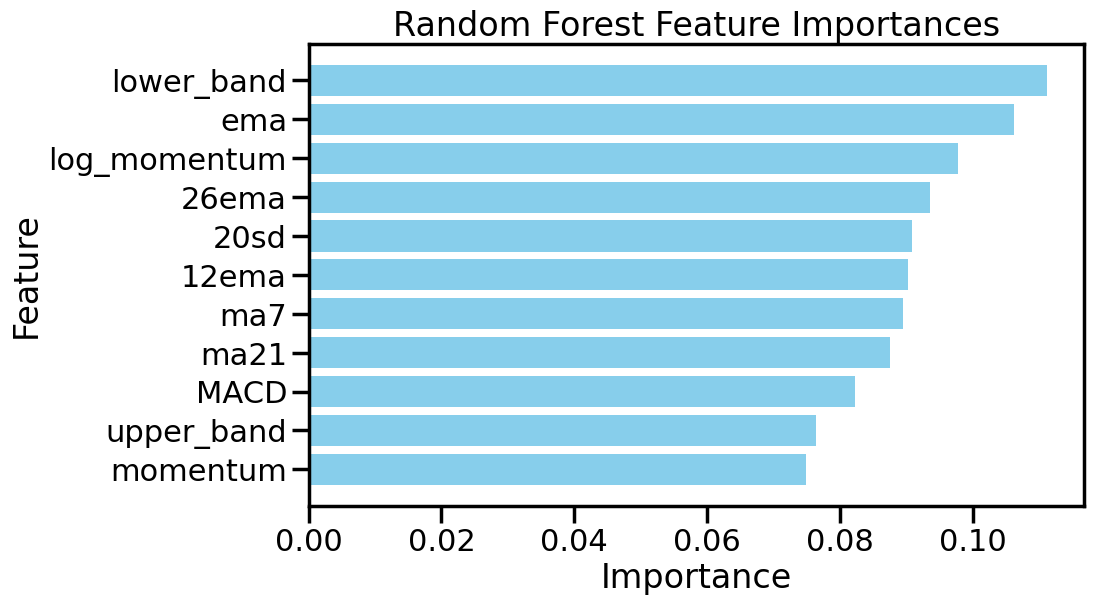

In [11]:
# Random Forest Classification

# Prepare Data
if 'Date' not in df.columns:
    df['Date'] = df.index

# Label Definition
# Next day up = 1, down = 0
df['Target'] = (df['Price'].shift(-1) > df['Price']).astype(int)
df_model = df.dropna(subset=['Target']).reset_index(drop=True)

# Feature Selection
feature_cols = [
    'ma7', 'ma21', '26ema', '12ema', 'MACD',
    '20sd', 'upper_band', 'lower_band', 'ema',
    'momentum', 'log_momentum'
]

X = df_model[feature_cols]
y = df_model['Target']

# Train/Test Split
last_date = df_model['Date'].max()
one_year_ago = last_date - pd.DateOffset(years=1)

test_mask = df_model['Date'] >= one_year_ago
X_test = X[test_mask]
y_test = y[test_mask]
X_train = X[~test_mask]
y_train = y[~test_mask]

# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train_scaled, y_train)

# Predict
y_pred = rf.predict(X_test_scaled)

# Evaluate
print("=== Random Forest Classification Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Feature Importance
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n=== Feature Importances ===")
print(feature_importance_df)

# Plot Feature Importances
plt.figure(figsize=(10,6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()



Optimal number of features before Accuracy decreases: 4
Optimal number of features before F1 Score decreases: 4


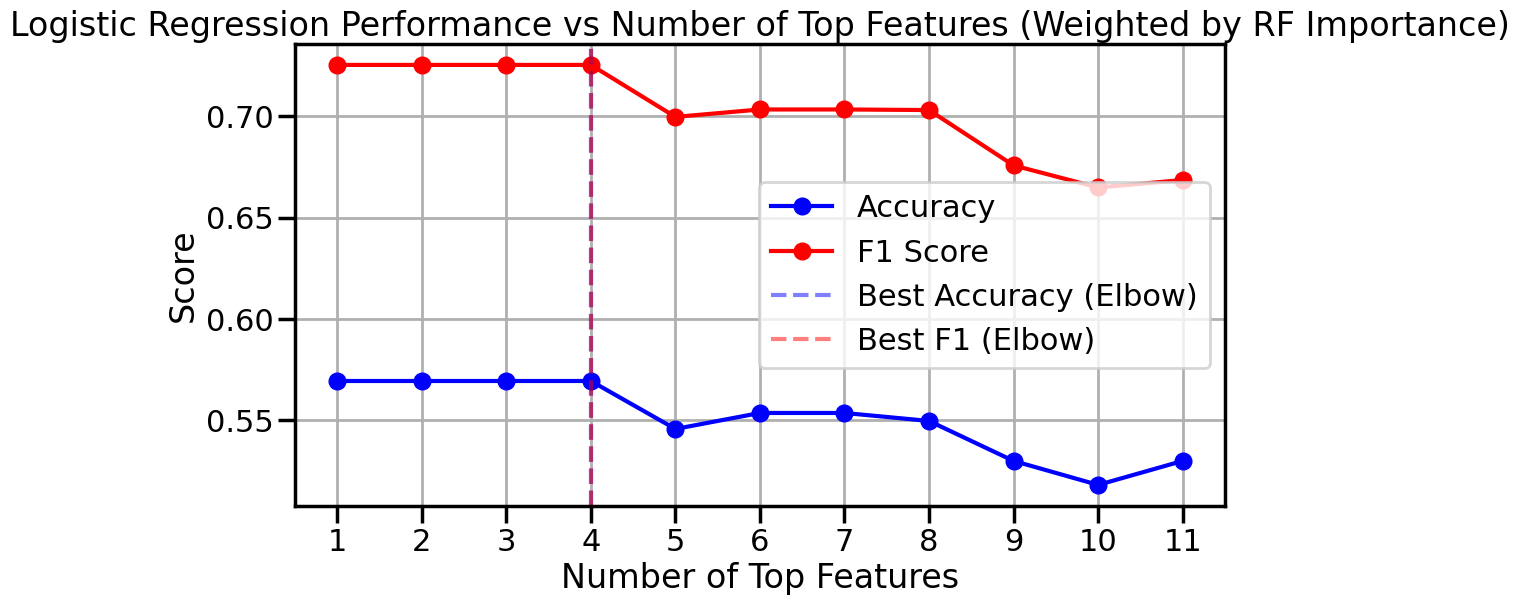

In [12]:
# Optimize Number of Features for Logistic Regression using RF Importance

# Sort features by Random Forest importance
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

sorted_features = feature_importance_df['Feature'].values
sorted_importances = feature_importance_df['Importance'].values
sorted_importances_norm = sorted_importances / sorted_importances.sum()

# Test different numbers of top features
max_features = len(sorted_features)
results = []

for n_top in range(1, max_features + 1):
    # Select top-n features
    top_features = sorted_features[:n_top]
    top_importances = sorted_importances_norm[:n_top]

    # Prepare weighted features
    X_train_top = X_train_scaled[:, [feature_cols.index(f) for f in top_features]] * top_importances
    X_test_top = X_test_scaled[:, [feature_cols.index(f) for f in top_features]] * top_importances

    # Train Logistic Regression
    logreg = LogisticRegression(max_iter=1000, random_state=42)
    logreg.fit(X_train_top, y_train)

    # Predict
    y_pred_top = logreg.predict(X_test_top)

    # Evaluate
    acc = accuracy_score(y_test, y_pred_top)
    f1 = f1_score(y_test, y_pred_top)
    results.append({'n_features': n_top, 'accuracy': acc, 'f1': f1})

results_df = pd.DataFrame(results)

# Choose number of features before decrease
def find_elbow(scores):
    """Return index of last increase before first decrease."""
    for i in range(1, len(scores)):
        if scores[i] < scores[i-1]:
            return i
    return len(scores)

best_acc_features = find_elbow(results_df['accuracy'].values)
best_f1_features = find_elbow(results_df['f1'].values)

print(f"Optimal number of features before Accuracy decreases: {best_acc_features}")
print(f"Optimal number of features before F1 Score decreases: {best_f1_features}")

# Plot Accuracy & F1 vs Number of Features
plt.figure(figsize=(12,6))
plt.plot(results_df['n_features'], results_df['accuracy'], marker='o', label='Accuracy', color='blue')
plt.plot(results_df['n_features'], results_df['f1'], marker='o', label='F1 Score', color='red')
plt.axvline(best_acc_features, color='blue', linestyle='--', alpha=0.5, label='Best Accuracy (Elbow)')
plt.axvline(best_f1_features, color='red', linestyle='--', alpha=0.5, label='Best F1 (Elbow)')
plt.xticks(range(1, max_features+1))
plt.xlabel('Number of Top Features')
plt.ylabel('Score')
plt.title('Logistic Regression Performance vs Number of Top Features (Weighted by RF Importance)')
plt.legend()
plt.grid(True)
plt.show()


### Logistic Regression with Top Features from Random Forest

**Purpose:**  
This approach combines the interpretability of Logistic Regression with the feature selection capabilities of Random Forest. By using only the **most important features** ranked by Random Forest, the model aims to reduce noise from less informative indicators and improve directional prediction accuracy.

**Why Use This Approach:**  
- Reduces dimensionality: Focuses on the features that contribute most to prediction, improving model efficiency.  
- Combines strengths: Maintains Logistic Regression’s simplicity and interpretability while leveraging Random Forest’s nonlinear feature evaluation.  
- Potentially improves performance: Eliminates low-value features that may introduce noise or reduce accuracy.  

**Implementation Overview:**  
1. **Feature Selection:**  
   - Train a Random Forest model on all technical indicators.  
   - Rank features based on their importance scores.  
   - Select the top-k features for use in Logistic Regression.  
2. **Label Definition:** Convert price movement into binary labels:  
   - `1` if next-day close price is higher than today’s close.  
   - `0` if next-day close price is lower or unchanged.  
3. **Model Training:** Fit Logistic Regression on the training dataset using only the selected top features.  
4. **Prediction & Evaluation:** Assess performance using accuracy, F1-score, and confusion matrix to compare against baseline Logistic Regression and Random Forest models.


In [13]:
# Logistic Regression with Optimal Features from Random Forest

# Select optimal number of features from RF
n_optimal_features = best_f1_features
print(f"Using top {n_optimal_features} features for weighted Logistic Regression")

top_features = sorted_features[:n_optimal_features]
top_importances = sorted_importances_norm[:n_optimal_features]

# Prepare weighted features
X_train_opt = X_train_scaled[:, [feature_cols.index(f) for f in top_features]] * top_importances
X_test_opt = X_test_scaled[:, [feature_cols.index(f) for f in top_features]] * top_importances

# Train weighted Logistic Regression
logreg_weighted = LogisticRegression(max_iter=1000, random_state=42)
logreg_weighted.fit(X_train_opt, y_train)

# Predict
y_pred_weighted = logreg_weighted.predict(X_test_opt)

# Evaluate
print("=== Weighted Logistic Regression Evaluation (Top RF Features) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_weighted))
print("F1 Score:", f1_score(y_test, y_pred_weighted))
print("\nClassification Report:\n", classification_report(y_test, y_pred_weighted))



Using top 4 features for weighted Logistic Regression
=== Weighted Logistic Regression Evaluation (Top RF Features) ===
Accuracy: 0.5691699604743083
F1 Score: 0.72544080604534

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.57      1.00      0.73       144

    accuracy                           0.57       253
   macro avg       0.28      0.50      0.36       253
weighted avg       0.32      0.57      0.41       253



c:\_VTCS\VT_CS5805\LSTM-Stock-Price-Prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\_VTCS\VT_CS5805\LSTM-Stock-Price-Prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\_VTCS\VT_CS5805\LSTM-Stock-Price-Prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

In [14]:
# Logistic Regression vs Random Forest vs Weighted Logistic Regression Comparison

y_pred_lr = logreg.predict(X_test_scaled)
y_pred_rf = rf.predict(X_test_scaled)

# Summary metrics
print("=== Model Comparison: Accuracy & F1 Score ===")
print(f"Logistic Regression:     Accuracy={accuracy_score(y_test, y_pred_lr):.4f}, F1={f1_score(y_test, y_pred_lr):.4f}")
print(f"Random Forest:           Accuracy={accuracy_score(y_test, y_pred_rf):.4f}, F1={f1_score(y_test, y_pred_rf):.4f}")
print(f"Weighted LR (Top RF):    Accuracy={accuracy_score(y_test, y_pred_weighted):.4f}, F1={f1_score(y_test, y_pred_weighted):.4f}")

# Classification reports
print("\n=== Logistic Regression Classification Report ===")
print(classification_report(y_test, y_pred_lr))

print("\n=== Random Forest Classification Report ===")
print(classification_report(y_test, y_pred_rf))

print("\n=== Weighted Logistic Regression (Top RF Features) Classification Report ===")
print(classification_report(y_test, y_pred_weighted))


=== Model Comparison: Accuracy & F1 Score ===
Logistic Regression:     Accuracy=0.5217, F1=0.6409
Random Forest:           Accuracy=0.4348, F1=0.0138
Weighted LR (Top RF):    Accuracy=0.5692, F1=0.7254

=== Logistic Regression Classification Report ===
              precision    recall  f1-score   support

           0       0.40      0.22      0.28       109
           1       0.56      0.75      0.64       144

    accuracy                           0.52       253
   macro avg       0.48      0.49      0.46       253
weighted avg       0.49      0.52      0.49       253


=== Random Forest Classification Report ===
              precision    recall  f1-score   support

           0       0.43      1.00      0.60       109
           1       1.00      0.01      0.01       144

    accuracy                           0.43       253
   macro avg       0.72      0.50      0.31       253
weighted avg       0.76      0.43      0.27       253


=== Weighted Logistic Regression (Top RF Featur

c:\_VTCS\VT_CS5805\LSTM-Stock-Price-Prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\_VTCS\VT_CS5805\LSTM-Stock-Price-Prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\_VTCS\VT_CS5805\LSTM-Stock-Price-Prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

## Long Short-Term Memory (LSTM) Networks

### Overview
Long Short-Term Memory (LSTM) networks are a type of Recurrent Neural Network (RNN) designed to capture long-term dependencies in sequential data. In the context of stock price prediction, LSTMs are particularly effective at learning temporal patterns from historical price and technical indicator data.

### Purpose
The LSTM model in this project is used to predict the future stock closing prices based on past trends and technical indicators such as Moving Averages (MA), Relative Strength Index (RSI), MACD, and momentum indicators. Unlike traditional models, LSTMs can retain memory of past price movements, making them suitable for modeling time-series data.

### Key Steps
1. **Data Preparation:**  
   - Normalize the input features to scale the data between 0 and 1.  
   - Create sequences of a fixed look-back window (e.g., 60 days) to use as input features for predicting the next day’s price.

2. **Model Architecture:**  
   - Input layer receives sequences of historical prices and indicators.  
   - One or more LSTM layers capture temporal dependencies.  
   - Dense layer outputs the predicted stock price.

3. **Training:**  
   - Loss function: Mean Squared Error (MSE) to minimize prediction errors.  
   - Optimizer: Adam for efficient gradient descent.  
   - Batch size and epochs are tuned for optimal performance.

4. **Prediction & Evaluation:**  
   - The trained LSTM predicts future stock prices for the test set.  
   - Predictions are compared with actual prices using metrics like RMSE and MAE.  
   - Visualization is used to assess model accuracy over time.

### Advantages of LSTM for Stock Prediction
- Can learn complex temporal patterns in stock price data.  
- Able to remember long-term trends and dependencies that traditional models might miss.  
- Suitable for sequential and time-series forecasting tasks.



In [15]:
# Number of rows in the dataset
total_rows = len(df)

# Index where 80% of data ends
split_index = int(total_rows * 0.8)

# Split the data
data_training = df.iloc[:split_index].copy()
data_testing = df.iloc[split_index:].copy()

print("Training data range:", data_training.index.min(), "to", data_training.index.max())
print("Testing data range:", data_testing.index.min(), "to", data_testing.index.max())


Training data range: 0 to 6674
Testing data range: 6675 to 8343


In [16]:
# Select only numeric columns
numeric_cols = data_training.select_dtypes(include=['float64', 'int64']).columns
data_training_numeric = data_training[numeric_cols]

# Scale numeric data
scalar = MinMaxScaler()
data_training_scaled = scalar.fit_transform(data_training_numeric)
print(data_training_scaled.shape)
data_training_scaled

(6675, 13)


array([[0.0035979 , 0.00357205, 0.00402344, ..., 0.55750998, 0.69628652,
        0.        ],
       [0.0035979 , 0.0035279 , 0.00399502, ..., 0.55920928, 0.71817216,
        0.        ],
       [0.00351512, 0.00350398, 0.00396523, ..., 0.55848128, 0.70864488,
        0.        ],
       ...,
       [0.9497963 , 0.93990287, 0.98112707, ..., 0.70043718, 0.73484067,
        1.        ],
       [0.96795003, 0.94852749, 0.98229943, ..., 0.71887474, 0.73668244,
        0.        ],
       [0.96488118, 0.95485367, 0.98260705, ..., 0.53221821, 0.71506742,
        1.        ]], shape=(6675, 13))

In [24]:
X_train = []
y_train = []

for i in range(60, data_training.shape[0]):
    X_train.append(data_training_scaled[i-60: i])
    y_train.append(data_training_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

regressor = Sequential()

regressor.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1))


regressor.summary()

c:\_VTCS\VT_CS5805\LSTM-Stock-Price-Prediction\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 60, 60)         │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 60, 60)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 60, 80)         │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,161 (707.66 KB)

 Trainable params: 181,161 (707.66 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs=50, batch_size = 64)

Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 0.0072
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0016
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0017
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0015
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0014
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0014
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0012
Epoch 8/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0014
Epoch 9/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0011
Epoch 10/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0012
Epoch 11/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0011
Epoch 12/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0012
Epoch 13/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0014
Epoch 14/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0011
Epoch 15/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s

In [19]:
# Combine last 60 days of training with testing data
past_60 = data_training.tail(60)
dt = pd.concat([past_60, data_testing], ignore_index=True)

# Select numeric columns only
numeric_cols = dt.select_dtypes(include=['float64', 'int64']).columns
dt_numeric = dt[numeric_cols]

# Scale numeric data
scalar = MinMaxScaler()
inputs = scalar.fit_transform(dt_numeric)

# Prepare sequences for LSTM
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])  # assuming 'Close' is column 0 of numeric_cols

X_test, y_test = np.array(X_test), np.array(y_test)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_test shape: (1669, 60, 13)
y_test shape: (1669,)


In [20]:
y_pred = regressor.predict(X_test)


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [21]:
# Number of numeric columns used for scaling
num_features = dt_numeric.shape[1]

# Rescale predictions
y_pred_rescaled = scalar.inverse_transform(
    np.concatenate([y_pred.reshape(-1,1), np.zeros((y_pred.shape[0], num_features-1))], axis=1)
)[:, 0]

# Rescale actual test values
y_test_rescaled = scalar.inverse_transform(
    np.concatenate([y_test.reshape(-1,1), np.zeros((y_test.shape[0], num_features-1))], axis=1)
)[:, 0]


## Model Predictions vs Actual Values

The following figures illustrate how the trained model performs in predicting stock prices over different periods. These charts compare the predicted values generated by the model to the actual observed prices. They help visualize:

- How well the model captures overall trends in the data.
- Short-term prediction accuracy.
- Performance degradation over longer prediction horizons.

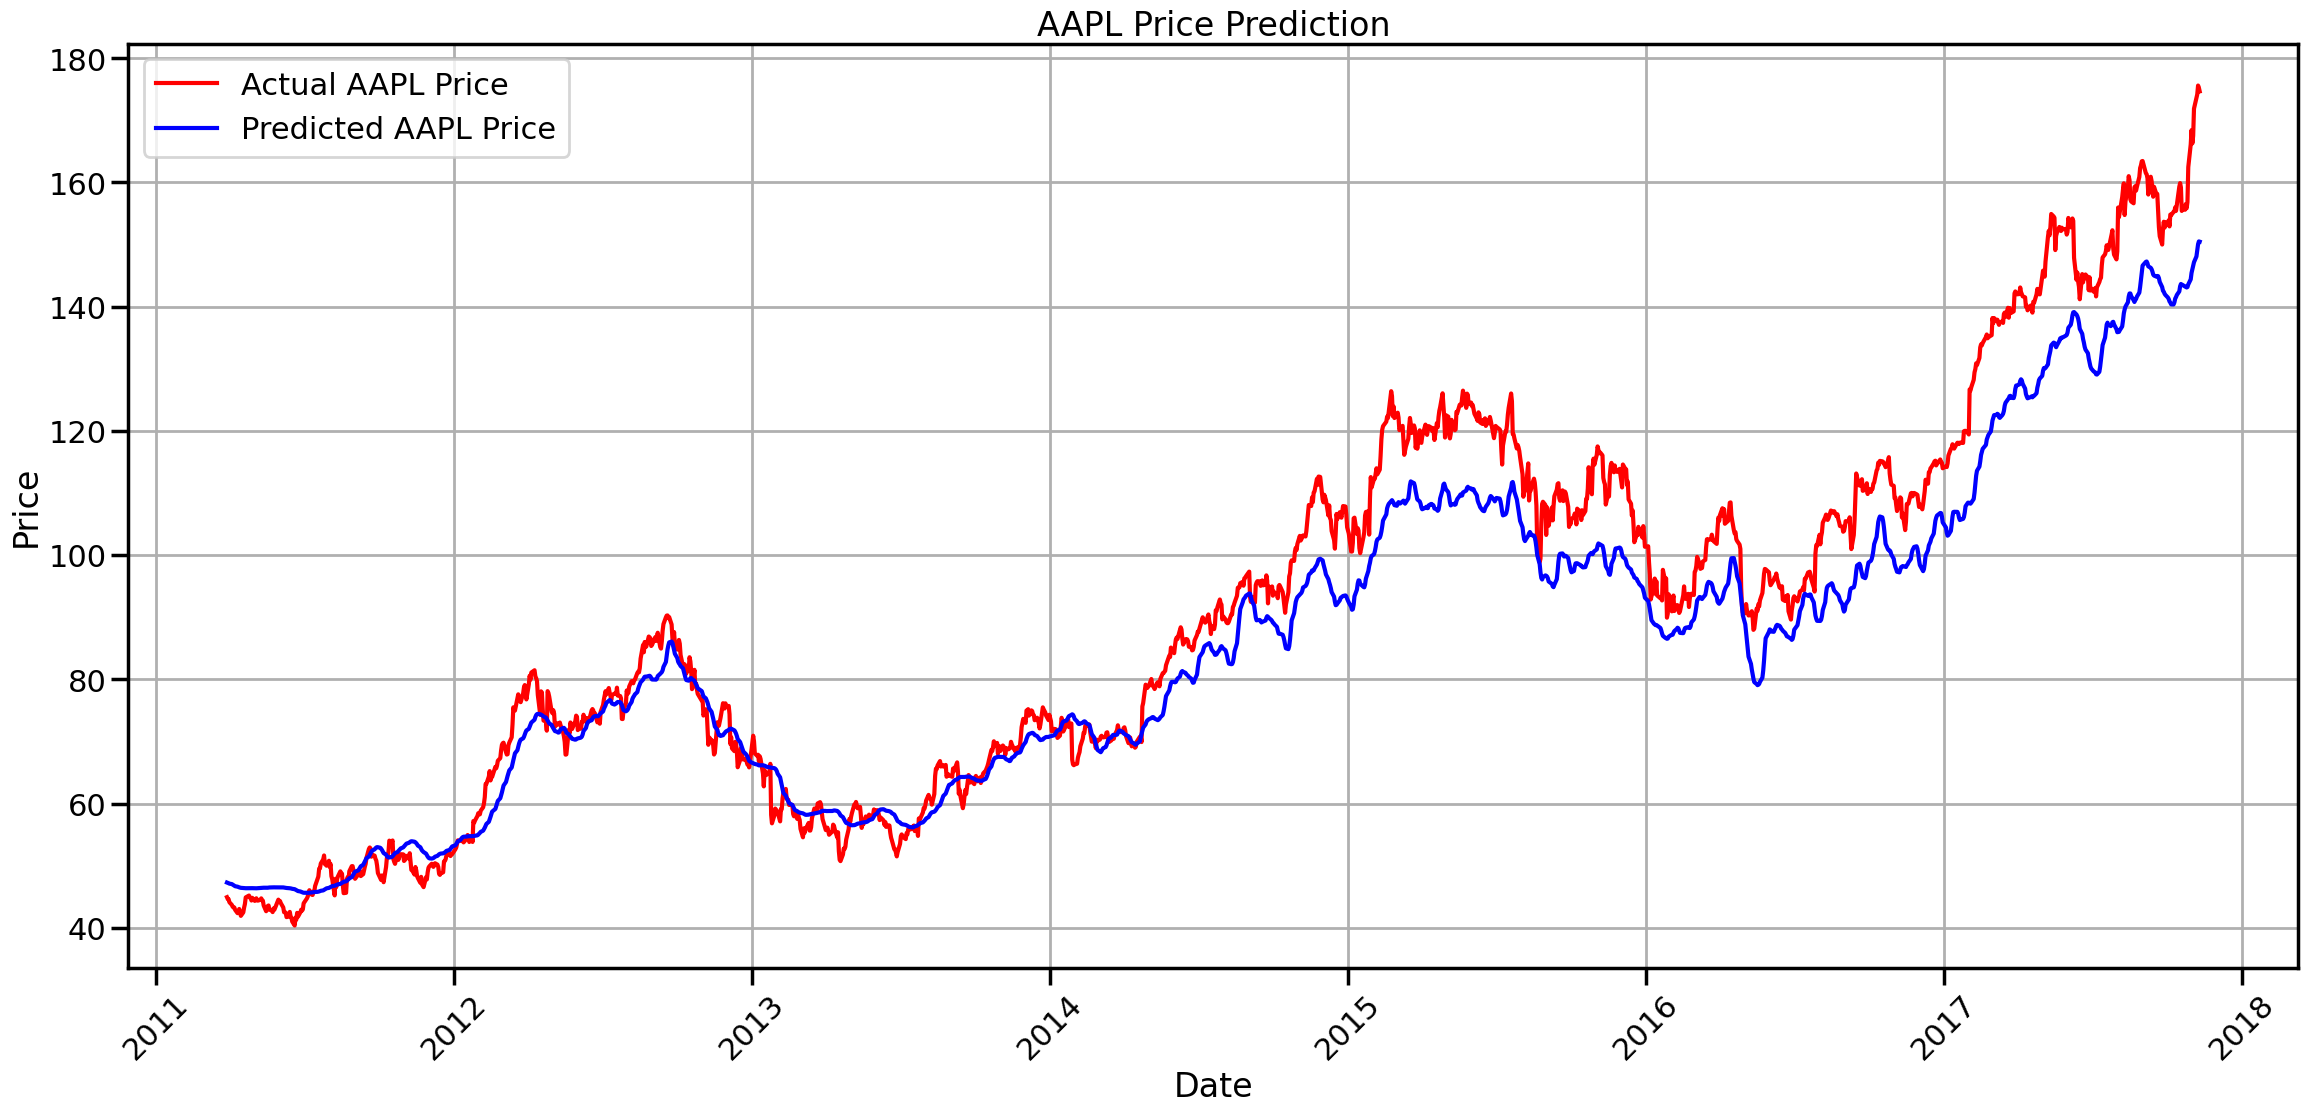

In [103]:
# Use the Date column from the test set
dates_for_plot = data_testing['Date'].iloc[-len(y_test_rescaled):].reset_index(drop=True)

# Plot actual vs predicted prices
plt.figure(figsize=(28,12))
plt.plot(dates_for_plot, y_test_rescaled, color='red', label=f'Actual {stock_name} Price')
plt.plot(dates_for_plot, y_pred_rescaled, color='blue', label=f'Predicted {stock_name} Price')
plt.title(f'{stock_name} Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


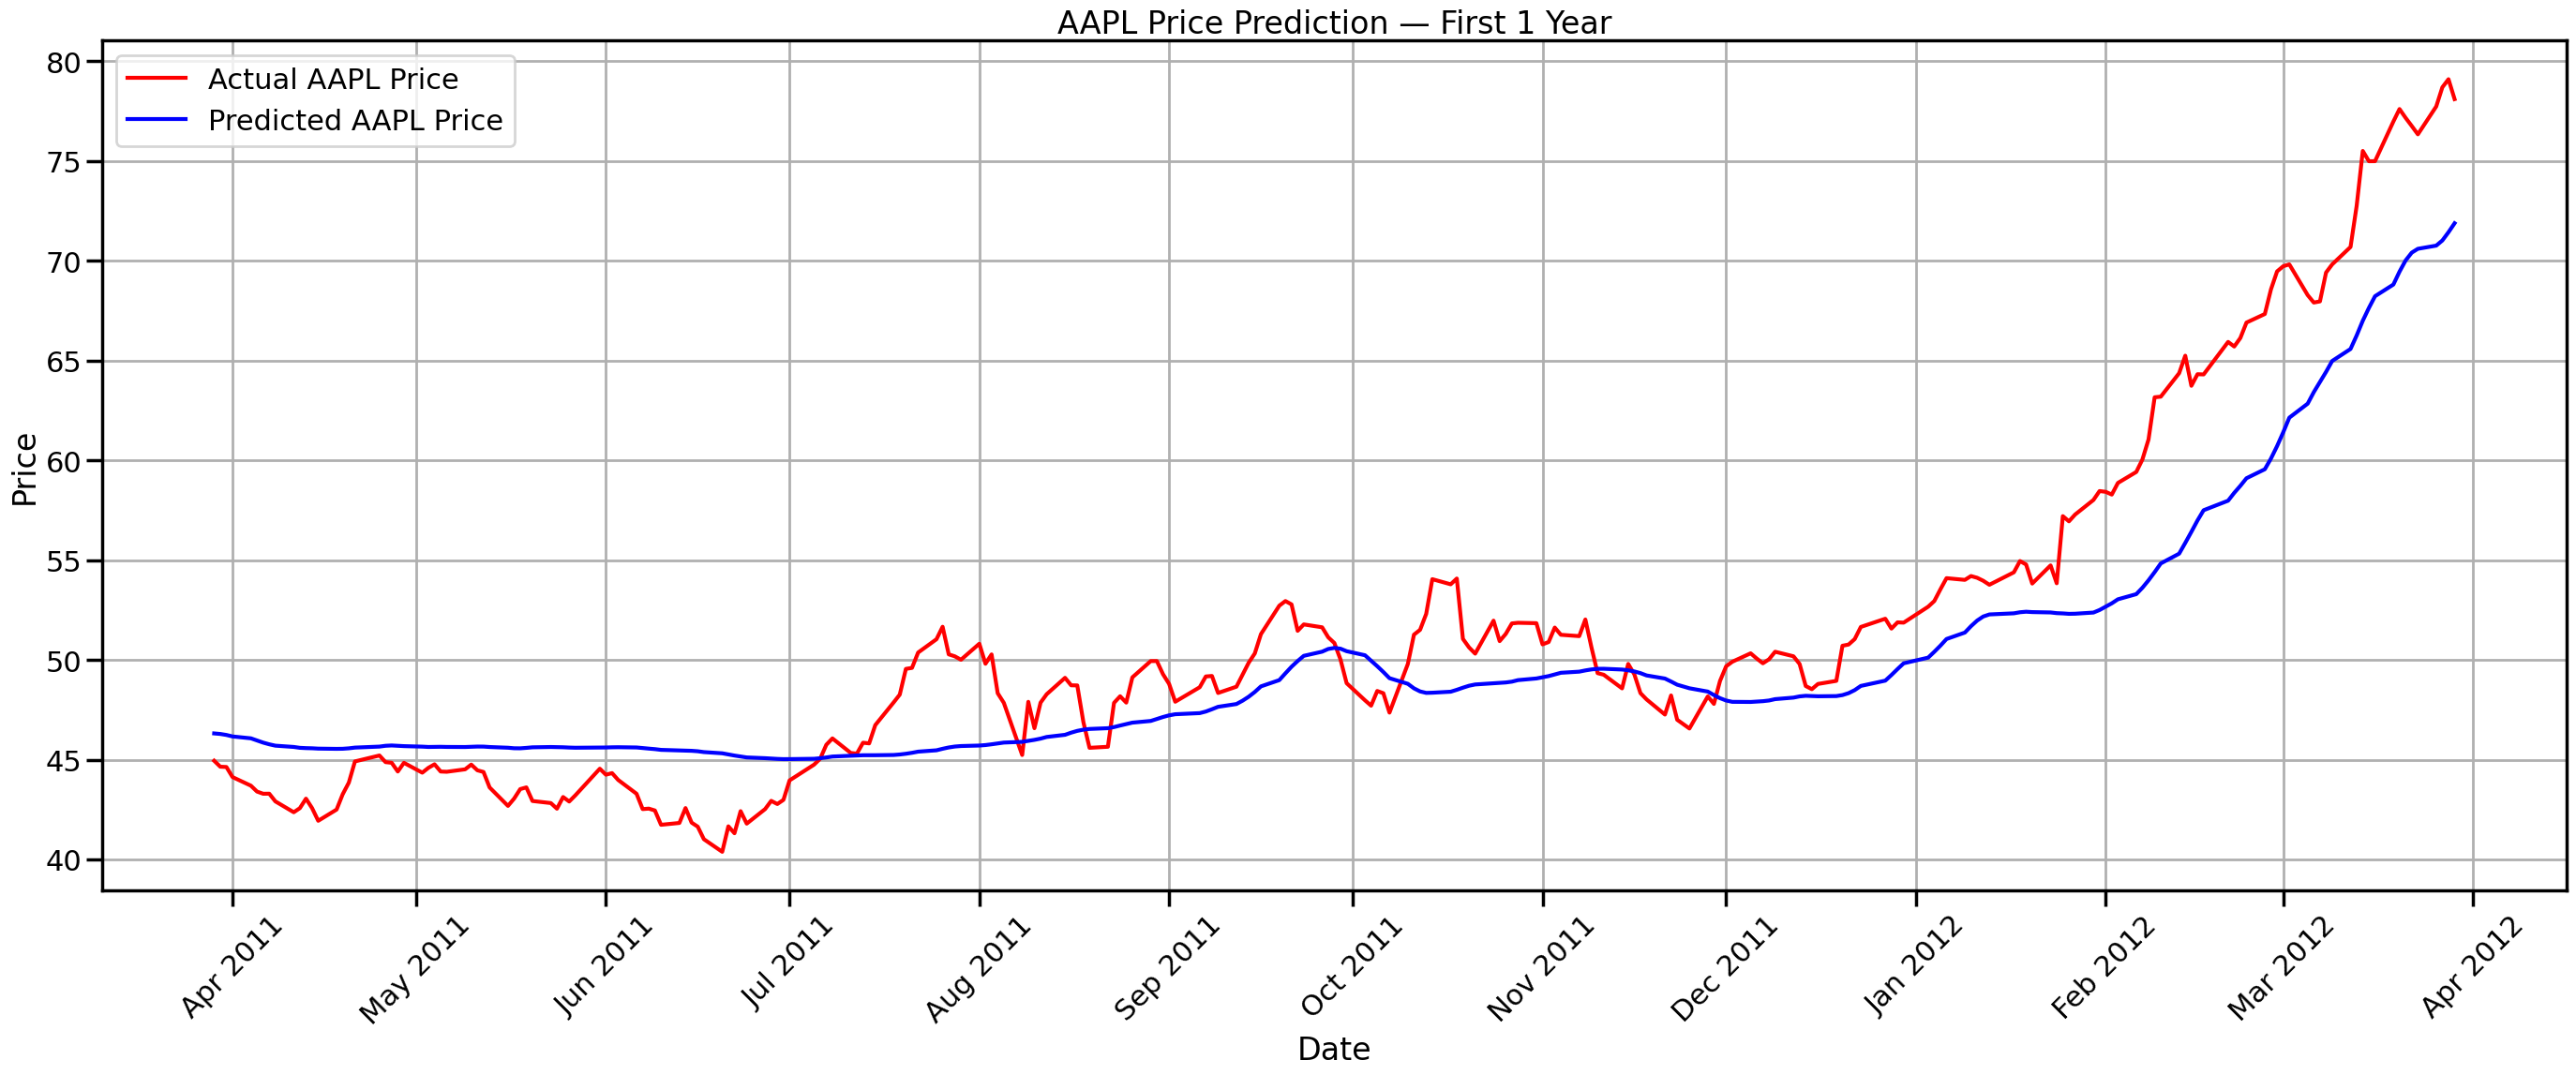

In [22]:
import matplotlib.dates as mdates

# Filter first 1 year from the test set
first_year_date = data_testing['Date'].min() + pd.DateOffset(years=1)
mask_first_year = data_testing['Date'] <= first_year_date

# Select actual dates and corresponding rescaled values
dates_first_year = data_testing.loc[mask_first_year, 'Date'].reset_index(drop=True)
y_test_first_year = y_test_rescaled[:len(dates_first_year)]
y_pred_first_year = y_pred_rescaled[:len(dates_first_year)]

# Plot
plt.figure(figsize=(28,12))
plt.plot(dates_first_year, y_test_first_year, color='red', label=f'Actual {stock_name} Price')
plt.plot(dates_first_year, y_pred_first_year, color='blue', label=f'Predicted {stock_name} Price')
plt.title(f'{stock_name} Price Prediction — First 1 Year')
plt.xlabel('Date')
plt.ylabel('Price')

# Format x-axis for better readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


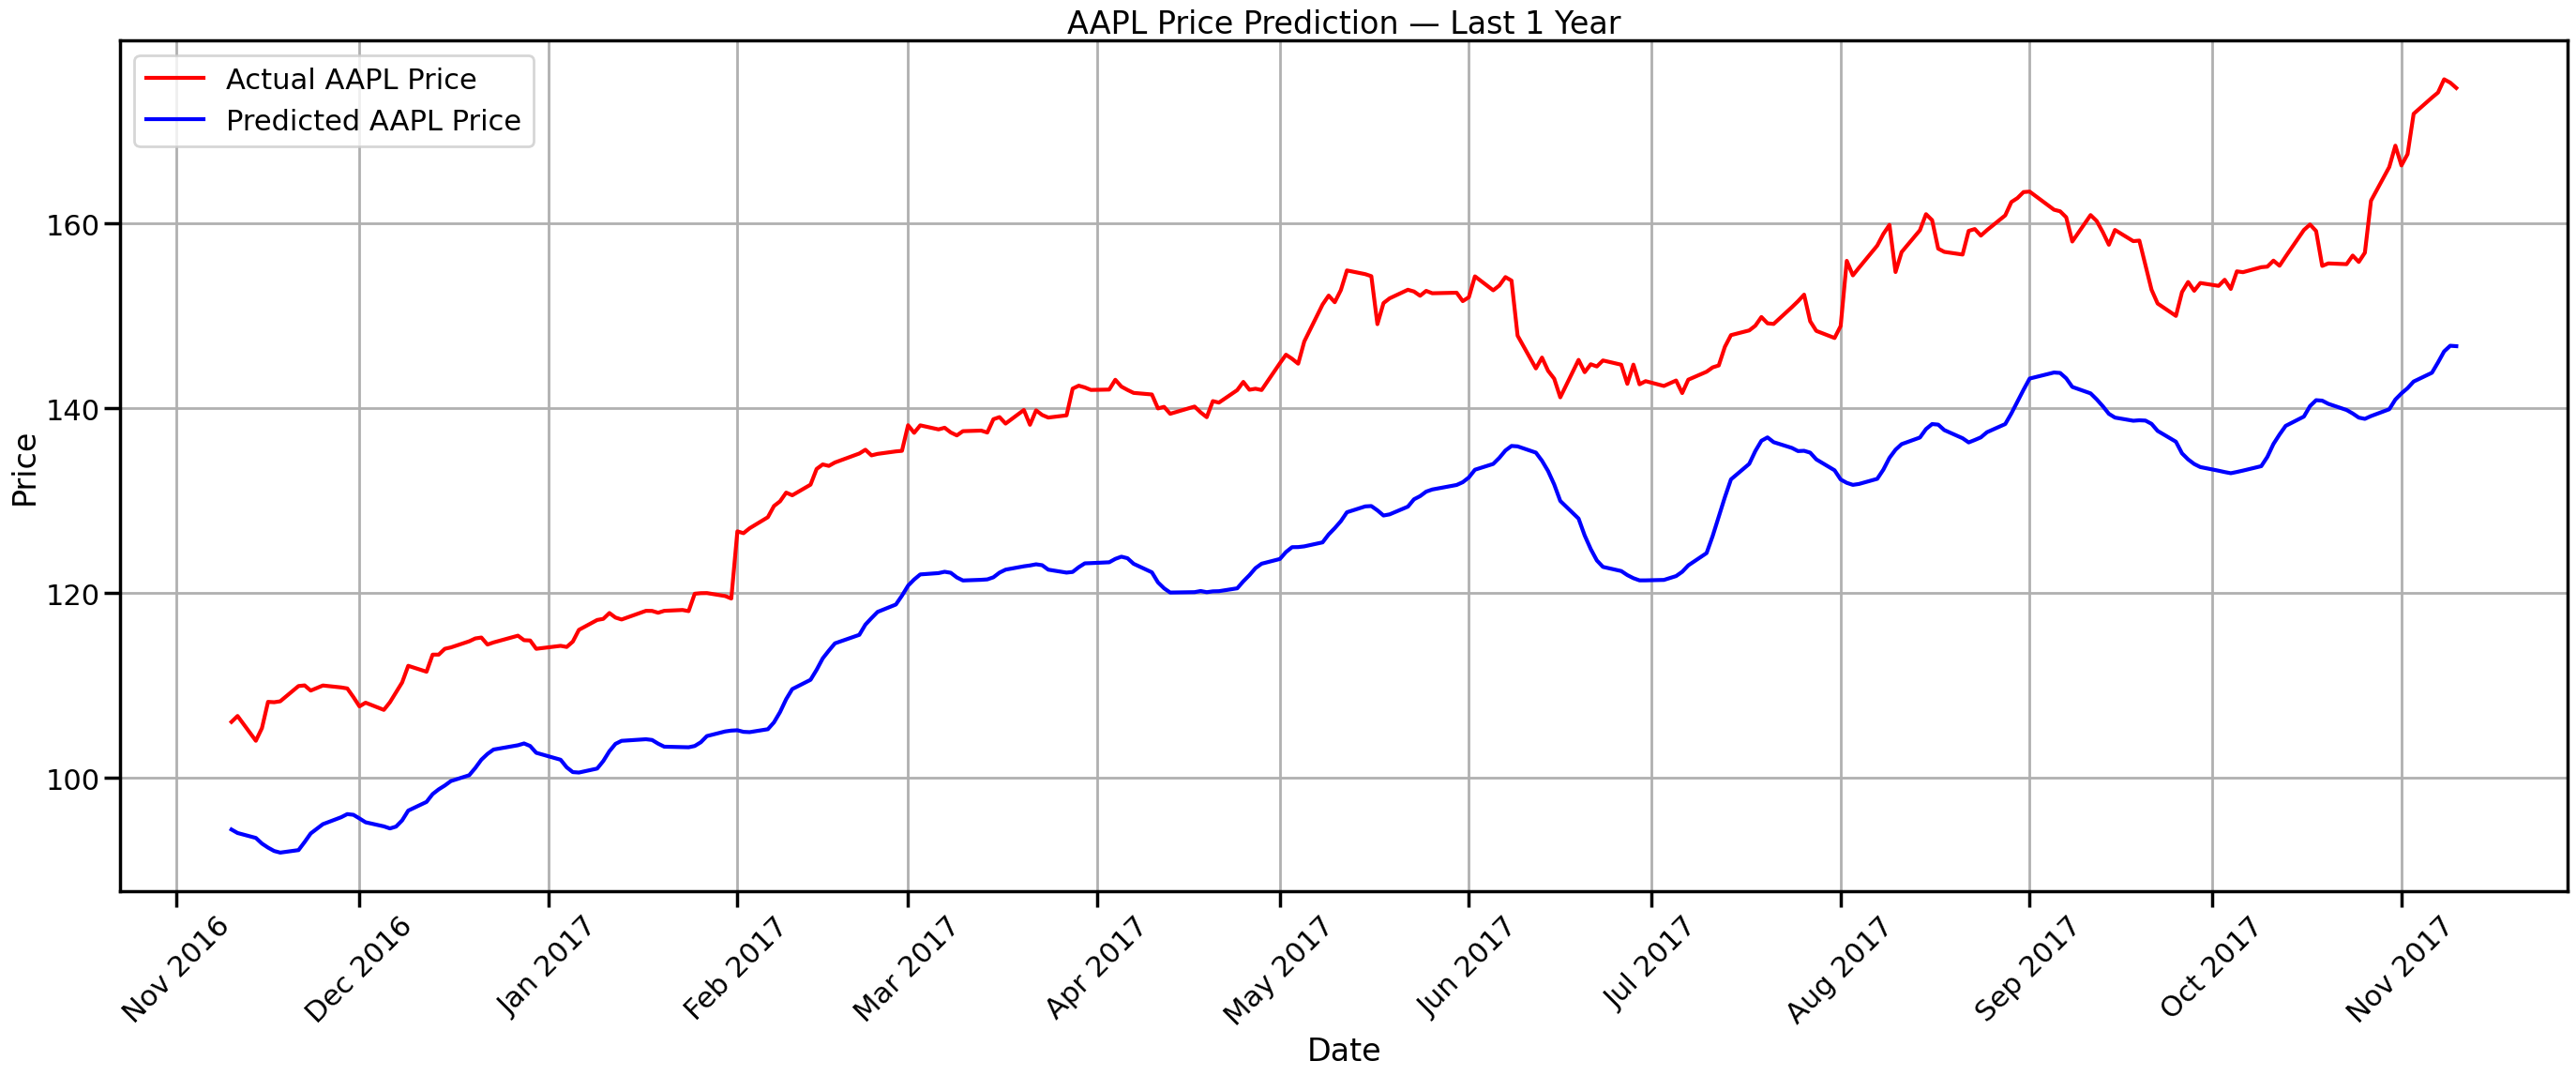

In [23]:
# Filter last 1 year from the test set
last_year_date = data_testing['Date'].max() - pd.DateOffset(years=1)
mask_last_year = data_testing['Date'] >= last_year_date

# Select actual dates and corresponding rescaled values
dates_last_year = data_testing.loc[mask_last_year, 'Date'].reset_index(drop=True)
y_test_last_year = y_test_rescaled[-len(dates_last_year):]
y_pred_last_year = y_pred_rescaled[-len(dates_last_year):]

# Plot
plt.figure(figsize=(28,12))
plt.plot(dates_last_year, y_test_last_year, color='red', label=f'Actual {stock_name} Price')
plt.plot(dates_last_year, y_pred_last_year, color='blue', label=f'Predicted {stock_name} Price')
plt.title(f'{stock_name} Price Prediction — Last 1 Year')
plt.xlabel('Date')
plt.ylabel('Price')

# Format x-axis for better readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
